### Imports

In [ ]:
import torch
from torch import nn, optim
import torchvision.transforms.functional as TF
from torchvision import models
import torch.nn.functional as F

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader
from os import listdir
import os
from os.path import join
import cv2
import numpy as np

import matplotlib.pyplot as plt
from random import randint

png = './data/train/img/1803201916/img_00000000/1803201916-00000117.png'
if os.path.exists(png):
    _ = cv2.imread(png)
    cv2.imwrite(png[:-4]+'.jpg', _)
    os.remove(png)


### Data Preview

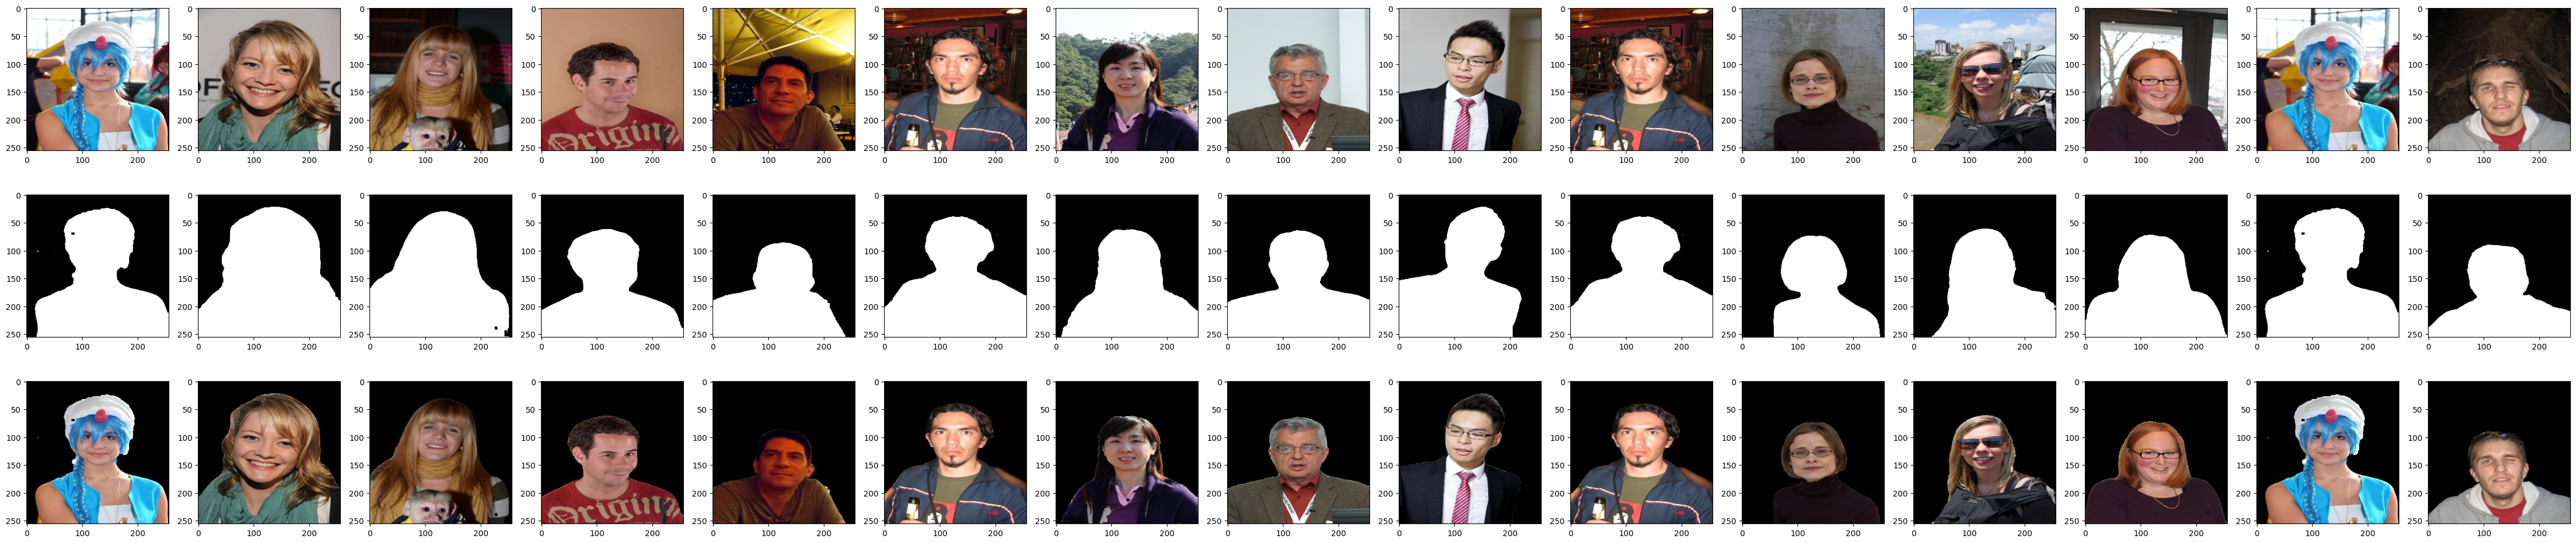

In [ ]:
x_base = 'data/val/img/1803290444/img_00000000/'
y_base = x_base.replace('img', 'mask')

tokens = listdir(x_base)
num = min(15, len(tokens))

fig, axes = plt.subplots(3, num, figsize=(num*3, 10))

for i in range(num):
    idx = randint(0, len(tokens))
    img = cv2.cvtColor(cv2.imread(x_base + tokens[idx]), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256)) # w, h
    
    msk = cv2.cvtColor(cv2.imread(y_base + tokens[idx]), cv2.COLOR_BGR2RGB)
    msk = cv2.resize(msk, (256, 256)) # w, h

    res = cv2.bitwise_and(img, msk)

    axes[0, i].imshow(img)
    axes[1, i].imshow(msk)
    axes[2, i].imshow(res)


plt.tight_layout()
plt.show()


### Model

In [ ]:
class DecoderBottleneck(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels, in_channels//4, kernel_size=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(in_channels//4)
        self.conv2 = nn.ConvTranspose2d(
            in_channels//4, in_channels//4, kernel_size=2, stride=2, bias=False
        )
        self.bn2 = nn.BatchNorm2d(in_channels//4)
        self.conv3 = nn.Conv2d(in_channels//4, in_channels//2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(in_channels//2)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, in_channels//2, kernel_size=2, stride=2, bias=False
            ),
            nn.BatchNorm2d(in_channels//2)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class LastBottleneck(nn.Module):
    def __init__(self, in_channels):
        super(LastBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, in_channels//4, kernel_size=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(in_channels//4)
        self.conv2 = nn.Conv2d(
            in_channels//4, in_channels // 4, kernel_size=3, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(in_channels//4)
        self.conv3 = nn.Conv2d(in_channels//4, in_channels//4, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(in_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, in_channels//4, kernel_size=1, bias=False),
            nn.BatchNorm2d(in_channels//4)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class SegResNet(nn.Module):
    def __init__(self, num_classes=1, in_channels=3):
        super().__init__()
        resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        encoder = list(resnet50.children())

        if in_channels != 3:
            encoder[0] = nn.Conv2d(
                in_channels, 64, kernel_size=3, stride=1, padding=1)

        encoder[3].return_indices = True  # MaxPool2D

        # encoder
        self.first_conv = nn.Sequential(*encoder[:4])
        resnet50_blocks = list(resnet50.children())[4:-2]
        self.encoder = nn.Sequential(*resnet50_blocks)

        # decoder
        resnet50_untrained = models.resnet50(pretrained=False)
        resnet50_blocks = list(resnet50_untrained.children())[4:-2][::-1]
        decoder = []
        channels = (2048, 1024, 512)

        for i, block in enumerate(resnet50_blocks[:-1]):
            new_block = list(block.children())[::-1][:-1]
            decoder.append(nn.Sequential(
                *new_block, DecoderBottleneck(channels[i])
            ))
        new_block = list(resnet50_blocks[-1].children())[::-1][:-1]
        decoder.append(nn.Sequential(*new_block, LastBottleneck(256)))

        self.decoder = nn.Sequential(*decoder)
        self.last_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, bias=False),
            nn.Conv2d(64, num_classes, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        # encoder
        x, indices = self.first_conv(x)
        x = self.encoder(x)

        # decoder
        x = self.decoder(x)
        x = F.max_unpool2d(x, indices, kernel_size=2, stride=2)
        x = self.last_conv(x)

        return x


### Dataset

In [ ]:
class SegDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.images = []
        self.transform = transform

        for sub1 in listdir(join(base_dir, 'img')):
            for sub2 in listdir(join(base_dir, 'img', sub1)):
                for fn in listdir(join(base_dir, 'img', sub1, sub2)):
                    self.images.append(join(base_dir, 'img', sub1, sub2, fn))
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.images[index].replace('img', 'mask'))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        return image / 255, mask / 255


### Utils

In [ ]:
def load_checkpoint(checkpoint, model):
    print('=> Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    print('=> Saving checkpoint')
    torch.save(state, filename)

def get_loaders(
        train_dir,
        val_dir,
        batch_size,
        train_transform,
        val_transform,
        num_workers=2,
        pin_memory=True
):
    train_ds = SegDataset(
        base_dir=train_dir,
        transform=train_transform
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
        drop_last=True,
    )

    val_ds = SegDataset(
        base_dir=val_dir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
        drop_last=True,
    )

    return train_loader, val_loader

def get_mean_std(loader):
    channels_sum, channels_squared_sum, n_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data.float(), dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data.float()**2, dim=[0, 2, 3])
        n_batches += 1

    mean = channels_sum / n_batches
    std = ((channels_squared_sum / n_batches) - mean**2) ** .5
    return mean, std

def model_eval(loader, model, device):
    n_correct = 0
    n_pixels = 0
    dice_score = 0

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.unsqueeze(1).to(device)

            preds = torch.sigmoid(model(x))
            preds = (preds > .5).float()

            n_correct += (preds == y).sum()
            n_pixels += torch.numel(preds)
            dice_score += (2*(preds*y).sum()) / ((preds+y).sum() + 1e-8)
    
    print(f'Accuracy: {(n_correct / n_pixels) * 100}, Dice-Score: {dice_score/len(loader)}')
    model.train()
    return float(dice_score/len(loader))


### Train

In [ ]:
# epochs: 1 + 5.
LR = 1e-4
BATCH_SIZE = 30
NUM_WORKERS = 2 # >> nproc or lscpu
PIN_MEMORY = True
LOAD_MODEL = True
NUM_EPOCHS = 5

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_IMAGE_DIR = './data/train/'
VAL_IMAGE_DIR = './data/val/'
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256


def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    for data, targets in loop:
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            preds = model(data)
            loss = loss_fn(preds, targets)
        
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


def main():
    train_transform = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.CLAHE(clip_limit=10, tile_grid_size=(8, 8), p=.5),
        A.Rotate(limit=45, p=.5),
        A.HorizontalFlip(p=.3),
        A.VerticalFlip(p=.2),
        A.RandomFog(fog_coef_lower=0.5, p=.2),
        A.RandomRain(p=.2),
        A.Sharpen(p=.2),
        ToTensorV2()
    ])
    val_transform = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2()
    ])

    model = SegResNet().to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    train_loader, val_loader = get_loaders(
        TRAIN_IMAGE_DIR,
        VAL_IMAGE_DIR,
        BATCH_SIZE,
        train_transform,
        val_transform,
        NUM_WORKERS,
        PIN_MEMORY
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load('checkpoint.pth.tar'), model)
    
    model.train()
    
    scaler = torch.cuda.amp.GradScaler()


    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        save_checkpoint(checkpoint)

        print('Epoch:', epoch, end=', ')
        dice_loss = model_eval(val_loader, model, DEVICE)

main()


=> Loading checkpoint


100%|██████████| 430/430 [03:17<00:00,  2.18it/s, loss=0.0534]


=> Saving checkpoint
Epoch: 0, Accuracy: 97.95320129394531, Dice-Score: 0.9859604239463806


100%|██████████| 430/430 [03:13<00:00,  2.22it/s, loss=0.0471]


=> Saving checkpoint
Epoch: 1, Accuracy: 98.05876922607422, Dice-Score: 0.9872217178344727


100%|██████████| 430/430 [03:11<00:00,  2.25it/s, loss=0.0922]


=> Saving checkpoint
Epoch: 2, Accuracy: 98.06182861328125, Dice-Score: 0.9872161746025085


100%|██████████| 430/430 [03:07<00:00,  2.29it/s, loss=0.0397]


=> Saving checkpoint
Epoch: 3, Accuracy: 98.17756652832031, Dice-Score: 0.9886002540588379


100%|██████████| 430/430 [03:10<00:00,  2.26it/s, loss=0.055]


=> Saving checkpoint
Epoch: 4, Accuracy: 98.19585418701172, Dice-Score: 0.9888404011726379


### Check Model performance/accuracy

In [ ]:
model = SegResNet()
load_checkpoint(torch.load('checkpoint.pth.tar'), model)
model.eval()

aug = A.Compose([
    A.CLAHE(clip_limit=10, tile_grid_size=(8, 8), p=.3),
    A.Rotate(limit=45, p=.7),
    A.HorizontalFlip(p=.6),
    A.VerticalFlip(p=.5),
    A.RandomFog(fog_coef_lower=0.5, p=.15),
    A.RandomRain(p=.15),
    A.Sharpen(p=.2),
])


val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    aug,
    ToTensorV2()
])

val_ds = SegDataset(
    base_dir='./data/val/',
    transform=val_transform
)

val_loader = DataLoader(
    val_ds,
    batch_size=10,
    num_workers=2,
    pin_memory=False,
    shuffle=False,
    drop_last=True
)

preds = []
X = []
Y = []

for x, y in tqdm(val_loader):
    with torch.no_grad():
        preds.append(model(x))
        X.append(x)
        Y.append(y)


=> Loading checkpoint


100%|██████████| 16/16 [01:24<00:00,  5.27s/it]


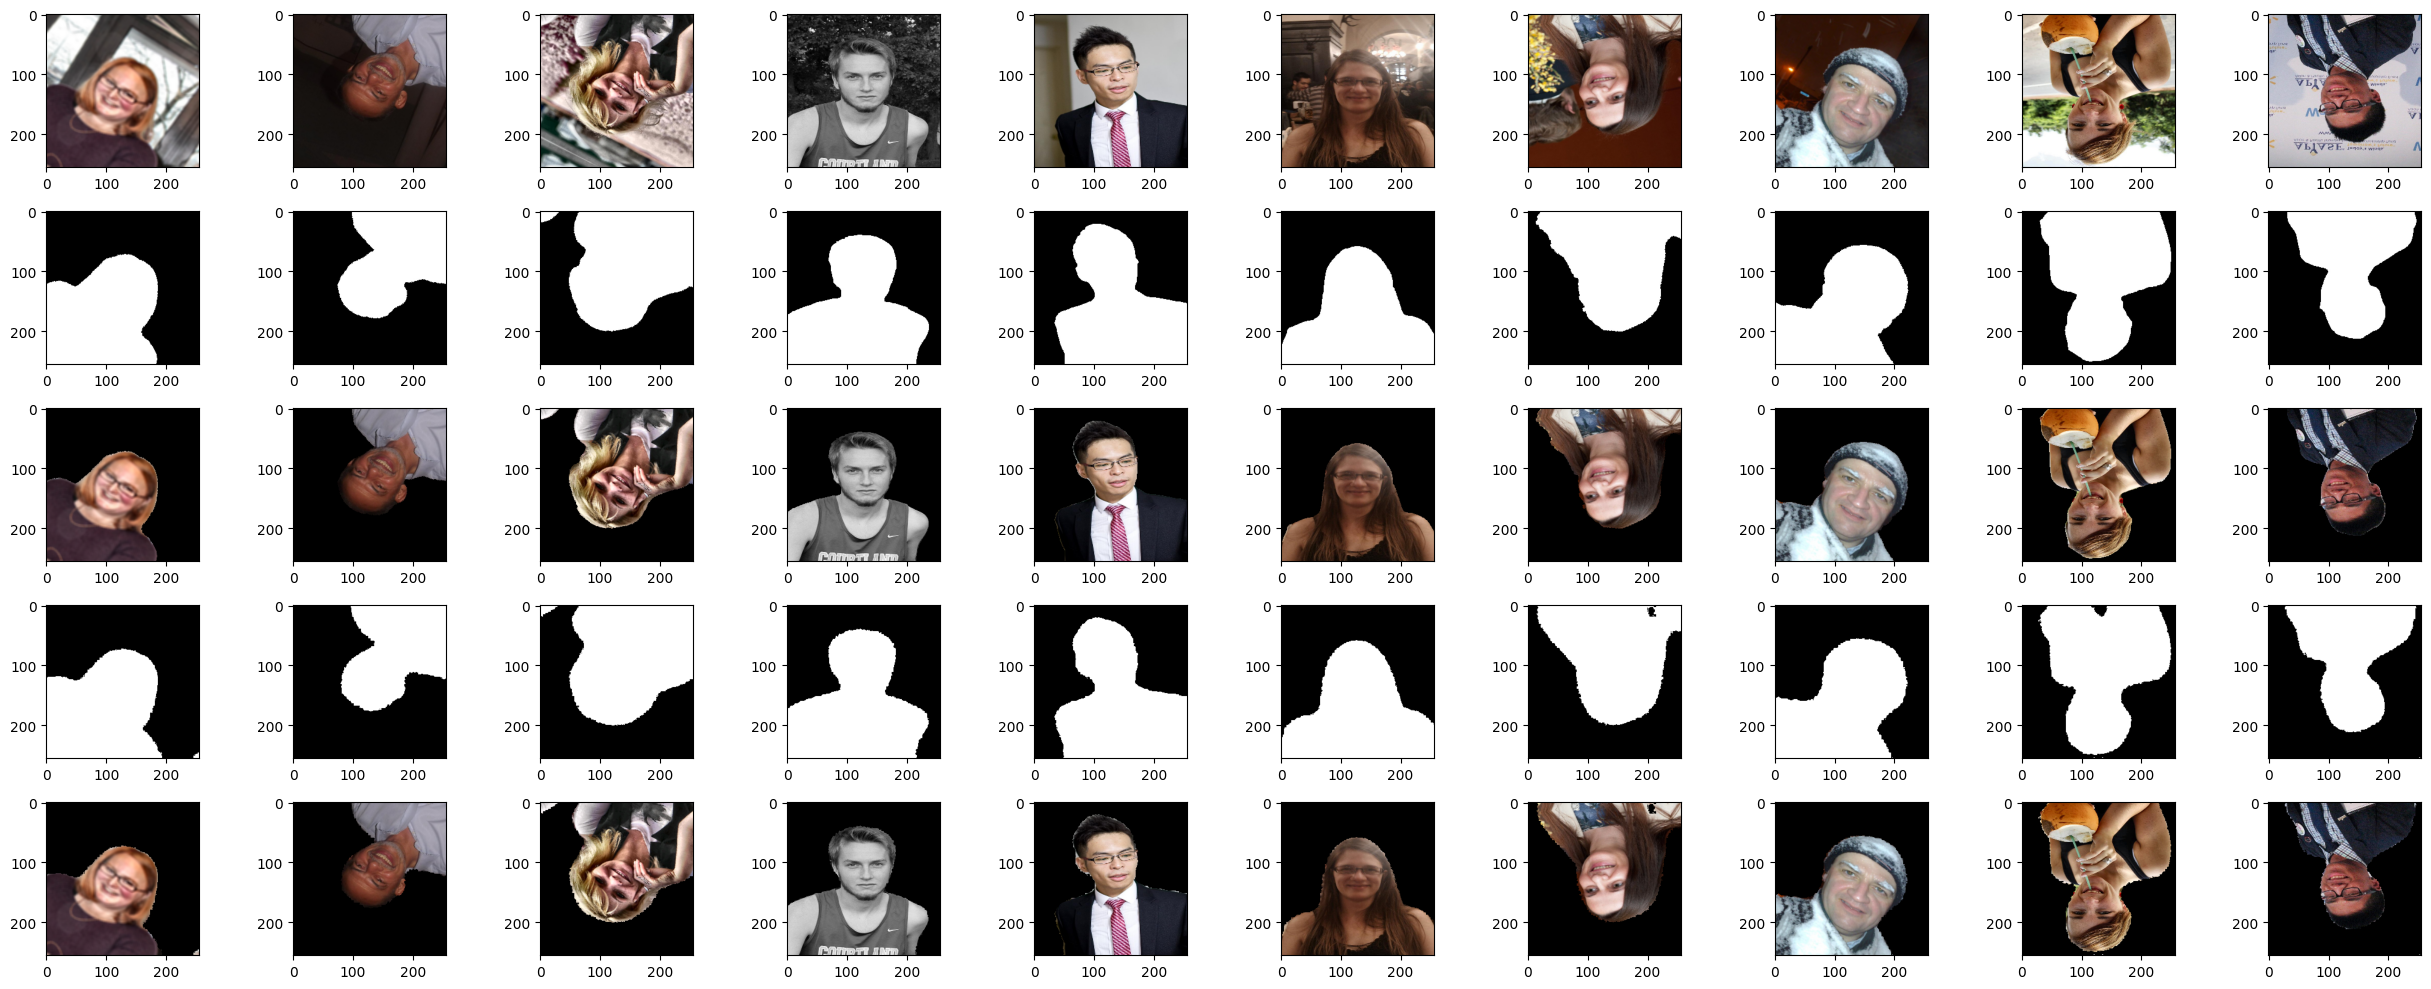

In [ ]:
# from random import randint
# batch_idx = randint(0, len(X)-1)

batch_idx = 3 # max 15

fig, axes = plt.subplots(5, 10, figsize=(25, 10))

Img = X[batch_idx]
Mask = Y[batch_idx]
Pred = preds[batch_idx]

for idx, (img, mask, pred) in enumerate(zip(Img, Mask, Pred)):
    img = (np.transpose(img.numpy(), (1, 2, 0)) * 255).astype('uint8')
    mask = (cv2.cvtColor(mask.numpy(), cv2.COLOR_GRAY2RGB) * 255).astype('uint8')
    pred = (torch.sigmoid(pred.detach()) > .5).float().numpy().squeeze()
    pred = (cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB) * 255).astype('uint8')

    truth_res = cv2.bitwise_and(img, mask)
    pred_res = cv2.bitwise_and(img, pred)

    axes[0, idx].imshow(img)
    axes[1, idx].imshow(mask)
    axes[2, idx].imshow(truth_res)
    axes[3, idx].imshow(pred)
    axes[4, idx].imshow(pred_res)

plt.tight_layout()
plt.show()


### Save model

In [ ]:
model = SegResNet()
load_checkpoint(torch.load('checkpoint.pth.tar'), model)

torch.save(model, 'segresnet_bg_seg_model.pth')

!zip segresnet_bg_seg_model.pth.zip segresnet_bg_seg_model.pth

=> Loading checkpoint
  adding: segresnet_bg_seg_model.pth (deflated 7%)
